<h1><b> Part 1: PixelCNN Implementation using TensorFlow <span style="color: #9370DB;">(50 Points)</span></b></h1> 

## **Introduction**
This assignment explores **PixelCNN**, a deep learning model designed for **generating images pixel-by-pixel** using **autoregressive modeling**. We apply this model to the **MNIST dataset**, which consists of handwritten digits, to understand how PixelCNN learns pixel dependencies and generates realistic digit images.

## **Objectives**
- Implement **PixelCNN** using TensorFlow/Keras.  
- Preprocess the **MNIST dataset** for binary pixel values.  
- Define custom **Pixel Convolutional Layers** and **Residual Blocks**.  
- Train the model to **generate images sequentially pixel by pixel**.  
- Evaluate model performance and visualize generated images.  

## **Dataset**
The **MNIST dataset** contains:
- **60,000 training images**  
- **10,000 testing images**  
Each image is **28×28 pixels** and represents a digit from **0 to 9**.

### Import Necessary Libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd  
import seaborn as sns  
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms
from IPython.display import Image, display
from tqdm import tqdm_notebook
import random

### Visualize the Dataset

In [13]:
def load_and_plot(num_samples):
    """
    TODO: Load the MNIST dataset, print the dataset shapes and plot a grid of random images from the training set.

    Parameters:
    num_samples (int): Number of images to plot in a grid.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    print(f'train set size: {len(train_dataset)}')
    print(f'train set size: {len(test_dataset)}')

    fig, axes = plt.subplots(int(num_samples ** 0.5), int(num_samples ** 0.5), figsize=(6, 6))
    for ax in axes.flatten():
        idx = random.randint(0, len(train_dataset) - 1)
        image, label = train_dataset[idx]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return train_dataset, test_dataset

### Preprocess the Dataset  

- Apply **binarization** to the images: Convert pixel values to either 0 or 1 based on a chosen threshold.  
- Convert the dataset to **float32** for compatibility with the model.  
- Reshape the dataset to include a **single channel** for grayscale images.  
- Print the **shapes** of the training and testing datasets to verify the preprocessing steps.  


train set size: 60000
train set size: 10000


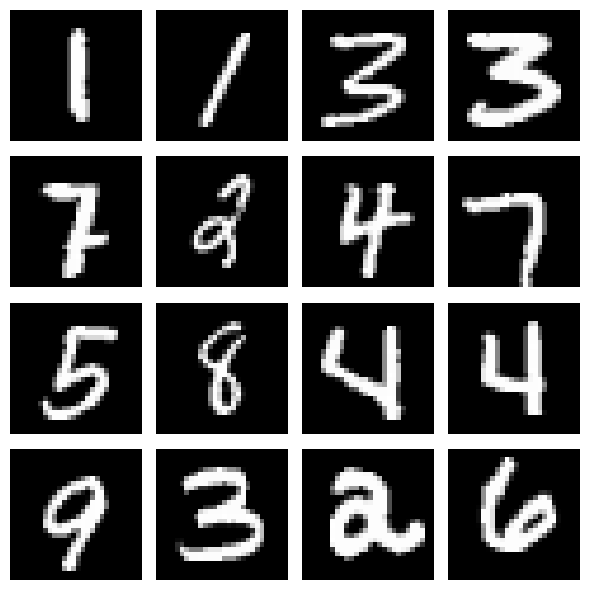

Train data shape: torch.Size([60000, 1, 28, 28])
Test data shape: torch.Size([10000, 1, 28, 28])


In [14]:
train_dataset, test_dataset = load_and_plot(16)

train_data = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
train_labels = torch.tensor([train_dataset[i][1] for i in range(len(train_dataset))])

test_data = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
test_labels = torch.tensor([test_dataset[i][1] for i in range(len(test_dataset))])

train_data = (train_data > 0.5).float()
test_data = (test_data > 0.5).float()

# Already in shape (N, 1, 28, 28), but confirm
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


### Implement `PixelConv` Class

1. **Initialize the Layer:**  
   - Define a convolutional layer with the given parameters.  
   - Store the mask type ('A' or 'B') as an instance variable.  

2. **Create a Mask in the `setup_layer` Method:**  
   - Generate a mask matrix that ensures autoregressive pixel dependencies.  
   - Implement different masking rules for **Mask Type A and Mask Type B**.  

3. **Apply the Mask in the `apply_mask` Method:**  
   - Multiply the convolution kernel with the mask before computing outputs.  
   - Ensure the layer respects the masked constraints during forward pass.  


In [43]:
class PixelConv(nn.Module):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, stride, padding, bias):  
        super(PixelConv, self).__init__()

        assert mask_type in ['A','B']
        self.mask_type = mask_type
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.register_buffer('mask', torch.ones_like(self.conv.weight))
        self.is_mask_setup = False
    
    def setup_layer(self, input_shape):
        kH, kW = self.conv.kernel_size
        yc, xc = kH // 2, kW // 2

        self.mask.fill_(1)

        for i in range(kH):
            for j in range(kW):
                if i > yc or (i == yc and j > xc):
                    self.mask[:, :, i, j] = 0
        if self.mask_type == 'A':
            self.mask[:, :, yc, xc] = 0 
    
    def forward(self, inputs):
        if not self.is_mask_setup:
            self.setup_layer(inputs.shape)
            self.is_mask_setup = True
    
        self.conv.weight.data *= self.mask
        return self.conv(inputs)

### Implement a Residual Block for PixelCNN

A residual block helps improve training stability and allows better gradient flow by adding shortcut connections. In this class, you will define a residual block using convolutional layers and a masked convolution.

### Steps to Implement:

1. **Initialize the Layers**  
   - Define convolutional layers and a masked convolutional layer.  
   - Ensure the masked convolution follows the correct masking strategy.  

2. **Forward Pass**  
   - Pass the input through the layers sequentially.  
   - Implement the residual connection by combining the input and output.  

In [44]:
class ResidualBlock(nn.Module):
    def __init__(self, filters, **kwargs):  
        super(ResidualBlock, self).__init__(**kwargs) 
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(filters, filters, kernel_size=1),
            nn.ReLU(),
            PixelConv(
                mask_type='B',
                in_channels=filters,
                out_channels=filters,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True
            ),
            nn.ReLU(),
            nn.Conv2d(filters, filters, kernel_size=1)
        )

    def forward(self, inputs):  
        out = self.block(inputs)
        return inputs + out

### Putting it Together

Now you will build a PixelCNN model using masked convolutions and residual blocks to model pixel dependencies.

### To-Do:
1. **Define the input layer** for grayscale images.  
2. **Add an initial masked convolution** to process input features.  
3. **Stack multiple residual blocks** to refine the learned representations.  
4. **Include additional masked convolutions** to further process the data.  
5. **Create an output layer** that predicts pixel values.  
6. **Ensure the total parameter count remains within 600,000.**  
7. **Display a summary** of your model and verify its structure and parameters.

In [45]:
# your code here
class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, num_residual_blocks=4):
        super(PixelCNN, self).__init__()

        self.input_conv = PixelConv(
            mask_type='A',
            in_channels=input_channels,
            out_channels=hidden_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            bias=True
        )


        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_channels) for _ in range(num_residual_blocks)]
        )

        self.conv_out = nn.Sequential(
            nn.ReLU(),
            PixelConv(mask_type='B', in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, 1, kernel_size=1)
        )


    def forward(self, x):
        x = self.input_conv(x)
        x = self.res_blocks(x)
        x = self.conv_out(x)
        return x


### Train your PixelCNN
You will now train the PixelCNN model and visualize its performance.

### To-Do:
1. **Compile the model** with an appropriate optimizer and loss function.  
2. **Train the model** for three different epoch settings: **10, 20, and 30**.  
3. **Plot the training and validation loss** for all three variations to analyze model performance over epochs.

In [54]:
def generate_images(model, num_images=4):
    model.eval()
    samples = torch.zeros((num_images, 1, 28, 28)).to(device)

    with torch.no_grad():
        for i in range(28):
            for j in range(28):
                out = model(samples)
                prob = torch.sigmoid(out[:, :, i, j])
                samples[:, :, i, j] = torch.bernoulli(prob)
    return samples.cpu()

def display_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
    for ax, img in zip(axes, images):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [55]:
def train_and_generate(model, train_data, val_data, num_epochs=30, batch_size=64, lr=1e-3):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model = model.to(device)
    criterion = criterion.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f} | Val Loss = {val_losses[-1]:.4f}")

        if epoch in [10, 20, 30]:
            samples = generate_images(model, num_images=4)
            display_images(samples, title=f"Generated Images at Epoch {epoch}")

    return train_losses, val_losses


You will generate images pixel by pixel using three different trained PixelCNN models:  
- Model trained for **10 epochs**  
- Model trained for **20 epochs**  
- Model trained for **30 epochs**  

Each model will sequentially predict pixel values to generate new images.  

### To-Do:  
1. **Set up the necessary structure** for image generation.  
2. **Leverage the trained model** to infer missing pixel values step by step.  
3. **Determine pixel values** based on predictions.  
4. **Run the process with different models** and observe the outcomes.  
5. **Compare the generated images** to analyze any differences.

Epoch 1: Train Loss = 0.1116 | Val Loss = 0.0933
Epoch 2: Train Loss = 0.0920 | Val Loss = 0.0905
Epoch 3: Train Loss = 0.0903 | Val Loss = 0.0894
Epoch 4: Train Loss = 0.0894 | Val Loss = 0.0896
Epoch 5: Train Loss = 0.0888 | Val Loss = 0.0881
Epoch 6: Train Loss = 0.0883 | Val Loss = 0.0879
Epoch 7: Train Loss = 0.0879 | Val Loss = 0.0875
Epoch 8: Train Loss = 0.0875 | Val Loss = 0.0872
Epoch 9: Train Loss = 0.0872 | Val Loss = 0.0870
Epoch 10: Train Loss = 0.0869 | Val Loss = 0.0868


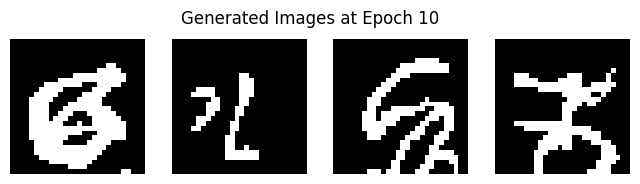

Epoch 11: Train Loss = 0.0867 | Val Loss = 0.0865
Epoch 12: Train Loss = 0.0865 | Val Loss = 0.0864
Epoch 13: Train Loss = 0.0863 | Val Loss = 0.0864
Epoch 14: Train Loss = 0.0861 | Val Loss = 0.0862
Epoch 15: Train Loss = 0.0860 | Val Loss = 0.0860
Epoch 16: Train Loss = 0.0858 | Val Loss = 0.0863
Epoch 17: Train Loss = 0.0857 | Val Loss = 0.0859
Epoch 18: Train Loss = 0.0856 | Val Loss = 0.0857
Epoch 19: Train Loss = 0.0855 | Val Loss = 0.0857
Epoch 20: Train Loss = 0.0854 | Val Loss = 0.0859


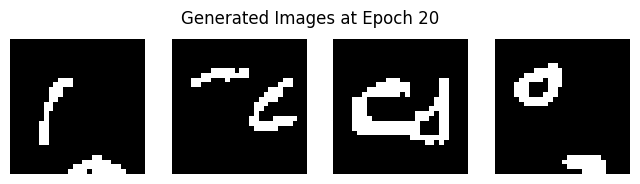

Epoch 21: Train Loss = 0.0853 | Val Loss = 0.0855
Epoch 22: Train Loss = 0.0852 | Val Loss = 0.0857
Epoch 23: Train Loss = 0.0852 | Val Loss = 0.0856
Epoch 24: Train Loss = 0.0851 | Val Loss = 0.0857
Epoch 25: Train Loss = 0.0850 | Val Loss = 0.0855
Epoch 26: Train Loss = 0.0850 | Val Loss = 0.0857
Epoch 27: Train Loss = 0.0849 | Val Loss = 0.0856
Epoch 28: Train Loss = 0.0848 | Val Loss = 0.0854
Epoch 29: Train Loss = 0.0848 | Val Loss = 0.0854
Epoch 30: Train Loss = 0.0847 | Val Loss = 0.0857


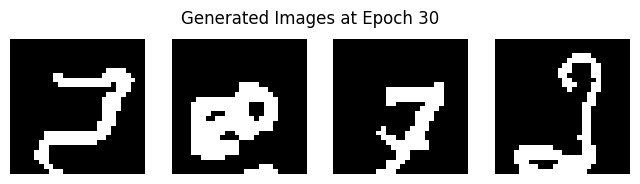

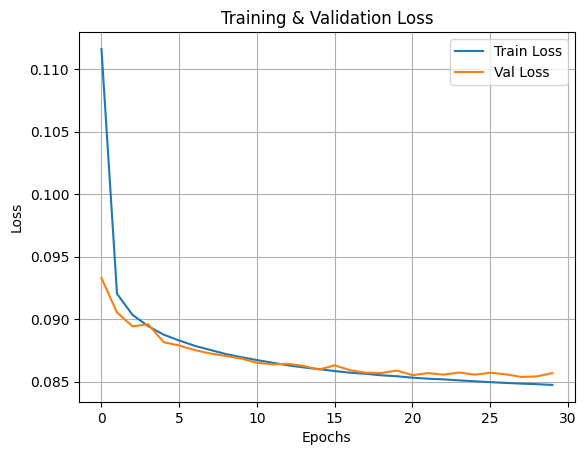

In [56]:
model = PixelCNN()
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(test_data, test_labels)

train_losses, val_losses = train_and_generate(model, train_dataset, val_dataset)
plot_losses(train_losses, val_losses)


## Reflection Questions  

After completing this part, take some time to reflect on the following questions:    


1. **How do the generated images differ across models trained for 10, 20, and 30 epochs?** What patterns or improvements do you notice with more training? 

Answer: At epoch 10 the images are very blurry, images generated lack any sort of structure, making it difficult to identify any number. Whereas the epoch 20 eventhough the loss reduced but still it wasnt clear or any sort of digit generated could be understood but it started to understand structure a bit. At epoch 30 the loss was reduced further and there a clear improvement in the representation of digits, they were better structured and less blurry.

2. **What role does the masked convolution play in PixelCNN?** How does it influence the way images are generated?

Answer: masked convolution ensures autoregressive generative behaviour by restricting receptive field of each pixel to only see pervious pixels during training and generation, allowing the cnn to predict one pixel at a time using the previous pixels. Enforcing sequential generation

<h1><b><span style="color: #9370DB;"> Part 1 Done!</span></h1>